**Part 2 - Model in 2D for f_WB using the IEM closure**

This notebook implements the interaction by exchange with the mean model (IEM) as introduced by (Dopazo, C. & O'Brien, E. 1974) and discussed by (Pope, S.B. 2010), in order to obtain a closure for the buoyancy equation

\begin{align}
    \frac{D \boldsymbol{U} }{Dt} &= -\nabla P + Re^{-1} \Delta \boldsymbol{U} + B \boldsymbol{\hat{z}}, \quad \nabla \cdot \boldsymbol{U} = 0, \\
    \frac{D B }{Dt}      &= Pe^{-1}  \Delta B.
\end{align}

We model the time evolution of the PDF $f_{\boldsymbol{Y}}$ for $\boldsymbol{Y} = (W,B)$.


*Evolution equation*

The joint pdf $f_{\boldsymbol{Y}}$ evolves according to 

\begin{equation}
    \frac{\partial f_{\boldsymbol{Y}} }{\partial t} = - \frac{\partial }{\partial b} \left[ \boldsymbol{D}^{(1)} f_{\boldsymbol{Y}} \right] - \frac{\partial }{\partial b} \left( \mathbb{E}_{\boldsymbol{Y}}[ \alpha  \Delta B ] f_{\boldsymbol{Y}} \right) - \frac{\partial }{\partial w} \left( \mathbb{E}_{\boldsymbol{Y}}[ \nu  \Delta W ] f_{\boldsymbol{Y}} \right) - \frac{\partial }{\partial w} \left( \mathbb{E}_{\boldsymbol{Y}}[ - \nabla_Z P + B ] f_{\boldsymbol{Y}} \right)
\end{equation}

The term $\boldsymbol{D}^{(1)}$ is responsible for forcing from internal heating or sources/sinks of buoyancy at the boundaries. Terms $\mathbb{E}_{\boldsymbol{Y}}[\alpha  \Delta B ]$ and $\mathbb{E}_{\boldsymbol{Y}}[ \nu  \Delta W ]$ are responsible for micro-scale molecular mixing locally in buoyancy space and in for viscous dissipation in velocity space. Both terms are unknown and must be modelled. The last term corresponds to the imbalance of the vertical pressure gradient and buoyancy conditioned on $\boldsymbol{Y}$. 

*Molecular mixing closure*

For the conditional diffusion term we will employ the IEM model. 
\begin{equation}
  \mathbb{E}_{\boldsymbol{Y}}[ \alpha \Delta B ] = -\frac{\alpha}{\tau_{B}(t)} \left( b - \mathbb{E}_W[B] \right),
\end{equation}

where $\tau_B(t)$ defines a characteristic time-scale of the buoyancy fluctuations.

*Velocity PDF closure*

For the conditional diffusion term we will employ the IEM model. 
\begin{equation}
  \mathbb{E}_{\boldsymbol{Y}}[ \alpha \Delta W ] f_{\boldsymbol{Y}} = \frac{\nu}{\tau_{W}(t)} \left( w - \mathbb{E}[W] \right) f_{\boldsymbol{Y}} - \frac{C_0 \epsilon}{2} \frac{\partial f_{\boldsymbol{Y}}}{\partial w},
\end{equation}

where $\tau_W(t)$ defines a characteristic time-scale of the velocity fluctuations.

*Pressure Gradient*

To model the vertical pressure gradient we can volume integrating the Boussinesq equations to obtain
\begin{equation}
\frac{1}{V} \int_{\Omega} \frac{\partial W}{\partial t} d \mathbb{x} = \frac{1}{V} \int_{\Omega} \left( -\nabla_Z P + B \right) d \mathbb{x}
\end{equation}
provided we have periodic boundary conditions or $W=0$ on the domain boundary $\partial \Omega$. This implies that the time-rate of change of the vertical velocity is zero if the system is in hydrostatic balance $\mathbb{E}[-\nabla_Z P + B] = 0$. This suggests at least to first order hydrostatic equilibrium may provide a good approximation. A variety of 2D simulations also support this conclusion. Expanding this relation we obtain

\begin{align*}
\mathbb{E}[-\nabla_Z P + B] &= 0,\\
\mathbb{E}_Y[-\nabla_Z P] &= -\mathbb{E}_W[B],\\
\mathbb{E}_Y[B-\nabla_Z P] &= \mathbb{E}_Y[B] - \mathbb{E}_W[B],\\
\mathbb{E}_W[ \mathbb{E}_Y[B] ] - \mathbb{E}_W[B] &= 0, \\
\end{align*}
and so we use the average of $B$ conditioned on $W$ ($\mathbb{E}_Y[-\nabla_Z P] = -\mathbb{E}_W[B]$) to model the conditional average of the vertical pressure gradient.

*Closed evolution equation*

Substituting the closures for the unknown terms we obtain

\begin{equation}
    \frac{\partial f_{\boldsymbol{Y}} }{\partial t} = - \frac{\partial }{\partial b} \left[ \boldsymbol{D}^{(1)} f_{\boldsymbol{Y}} \right] - \frac{\partial }{\partial w} \left( (b -\mathbb{E}_W[B]) f_{\boldsymbol{Y}} \right) + \frac{\alpha}{\tau_{B}(t)} \frac{\partial }{\partial b} \left[ \left( b - \mathbb{E}_W[B] \right) f_{\boldsymbol{Y}} \right] - \frac{\nu}{\tau_{W}(t)} \frac{\partial }{\partial w} \left[ \left( w - \mathbb{E}[W] \right) f_{\boldsymbol{Y}} \right] + \frac{C_0 \epsilon}{2} \frac{\partial^2 f_{\boldsymbol{Y}}}{\partial w^2}.
\end{equation}

which is an integro-differential equation, as

\begin{equation}
\mathbb{E}_W[B] = \int b f_{B|W}(b|w;t) db = \int b \frac{f_{WB}(w,b;t)}{f_W(w;t)} db,
\end{equation}

depends on the global PDF at each time-instant. Subject to specifying $\tau_B$ and $\tau_W$ and suitable boundary conditions this equation is closed and can be solved numerically.


Below we implement this equation using finite differences by specifying $\tau_B = \tau_W = 1$.

**Setup**

We first import the required libraries to implement this model.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid as trapz
from derivatives import *

We then define a computation grid for $f_{BW}(b,w;t)$ in terms of $b,w$. 

In [47]:
# Boundary conditions
bc_b = 'Neumann'
bc_w = 'Neumann'

# Numerical resolution
N_b = 64
N_w = 64 + 1

# Domain
b = np.linspace(-5, 5, N_b)
w = np.linspace(-10, 10, N_w) 

# Time-scales
𝜏_B = .75
𝜏_W = .75

We then define the operators to evolve the PDF.

In [48]:
def operators_EXP(b, w):
  
  from scipy.sparse import kron
  
  I_b = np.eye(len(b))
  I_w = np.eye(len(w)) 

  D_b = kron(sparse_grad(b),I_w)
  D_w = kron(I_b,sparse_grad(w))

  L_b = kron(sparse_laplacian(b,bcs=bc_b),I_w)
  L_w = kron(I_b,sparse_laplacian(w,bcs=bc_w)) 

  return L_b, L_w, D_b, D_w

def solve_EXP(f, b, w, Δt, L_b, L_w, D_b, D_w):

  # a) Compute diffusion from W
  W = np.kron(np.ones(N_b),w)
  B = np.kron(b,np.ones(N_w))
  
  # b.1) Compute the expectation velocity  
  EW_cB = trapz(y=(W*f).reshape((N_b,N_w)), x=w, axis=1)/trapz(y=f.reshape((N_b,N_w)), x=w, axis=1)
  EW_cB = np.kron(EW_cB, np.ones(N_w)) 
  
  # b.2) Compute the expectation buoyancy  
  EB_cW = trapz(y=(B*f).reshape((N_b,N_w)), x=b, axis=0)/trapz(y=f.reshape((N_b,N_w)), x=b, axis=0)
  EB_cW = np.kron(np.ones(N_b), EB_cW) 
  
  # c) Define the RHS
  RHS_w = -D_w@( B*f)          - (1/τ_W)*D_w@((B - EW_cB)*f) + 0.1*L_w@f
  RHS_b = -D_w@((B - EB_cW)*f) + (1/τ_B)*D_b@((B - EB_cW)*f) + 0.1*L_b@f
  
  # d) Update the PDF
  return f + Δt*(RHS_b + RHS_w)

We then wrap these in a time-stepping routine.

In [49]:
def solver(f, b, w, T, Δt):

  f_frames = []
  f_frames.append(f)

  L_b, L_w, D_b, D_w = operators_EXP(b, w) 

  # Loop over all time instants
  for n,t in enumerate(T):
  
    # 0) Plot the system out
    if n%(len(T)//10) == 0:
      print('int f_WB dwdb = %3.3f, t = %3.3f \n' %(trapz(y=trapz(y=f.reshape((N_b,N_w)),x=b,axis=0),x=w), t) )
      
      fig, ax = plt.subplots(nrows=2, ncols=2, layout='constrained')
      
      f_w = trapz(y=f.reshape((N_b,N_w)),x=b,axis=0)
      f_b = trapz(y=f.reshape((N_b,N_w)),x=w,axis=1)

      # First column
      ax[0,0].set_ylabel('$f_b$')
      ax[0,0].set_xlabel('$b$')
      ax[0,0].plot(b, f_b)

      ax[1,0].set_title(r'$f$')
      cf = ax[1,0].pcolormesh(b,w,f.reshape((len(b),len(w))).T, cmap='Reds')#, norm='log')
      #fig.colorbar(cf, ax=ax1)
      ax[1,0].set_xlabel('$b$')
      ax[1,0].set_ylabel('$w$')

      # First column
      fig.delaxes(ax[0,1])

      ax[1,1].set_ylabel('$w$')
      ax[1,1].set_xlabel('$f_w$')
      ax[1,1].plot(f_w, w)
      
      plt.show()

    # 1) Update the mapping
    #f = enforce_bc(f, b, w)
    f = solve_EXP(f, b, w, Δt, L_b, L_w, D_b, D_w)

    # 2) Grab the system state
    f_frames.append(f)

  return None

Finally we specify a time interval, initial conditions and time-step the system

Δt =  0.0001000010000100001
int f_WB(w,b;t=0) dwdb = 1.000 

int f_WB dwdb = 1.000, t = 0.000 



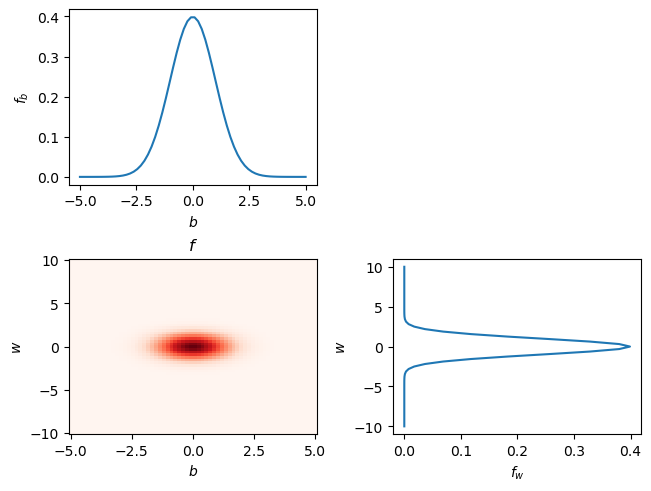

int f_WB dwdb = 1.000, t = 1.000 



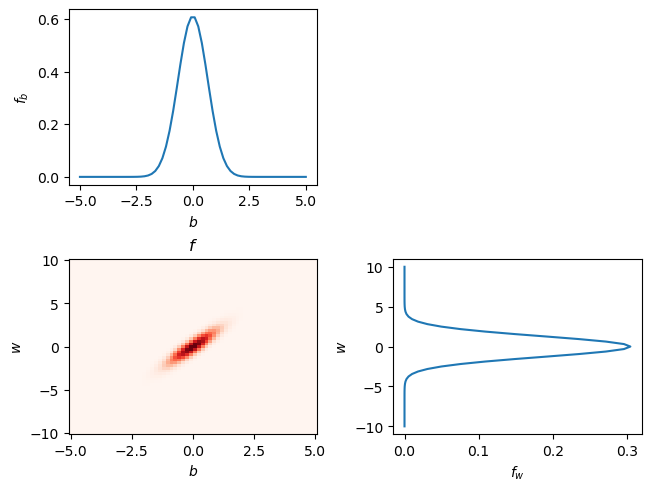

int f_WB dwdb = 1.000, t = 2.000 



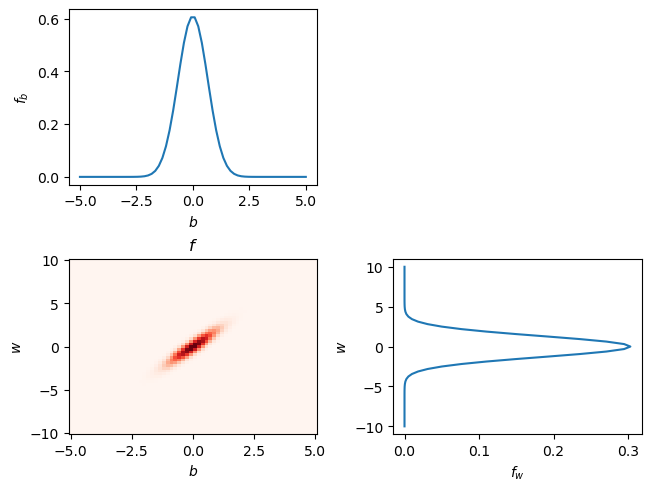

int f_WB dwdb = 1.000, t = 3.000 



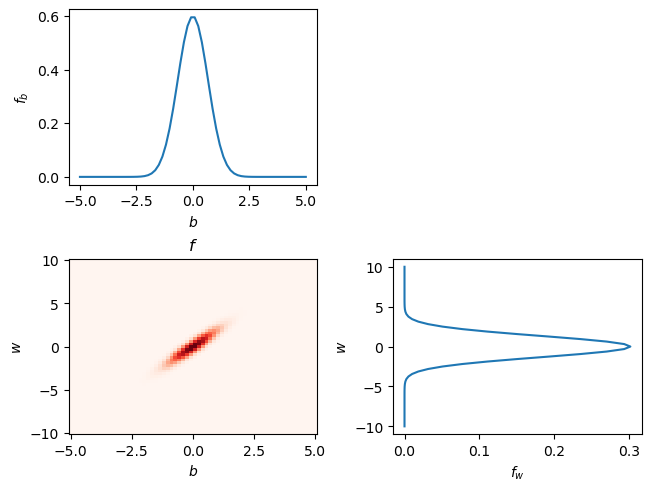

int f_WB dwdb = 1.000, t = 4.000 



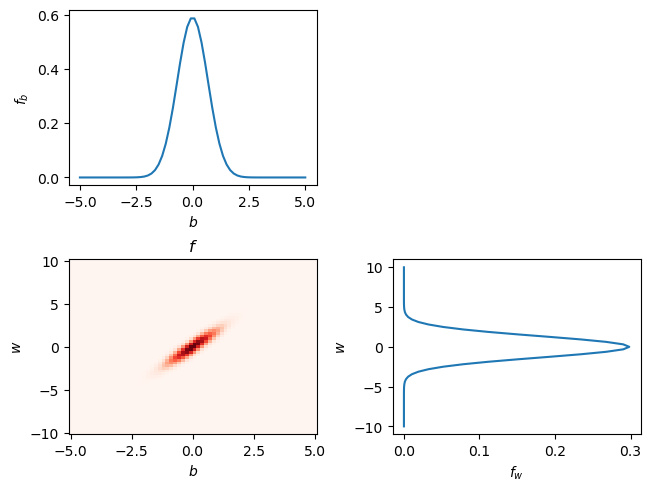

int f_WB dwdb = 1.000, t = 5.000 



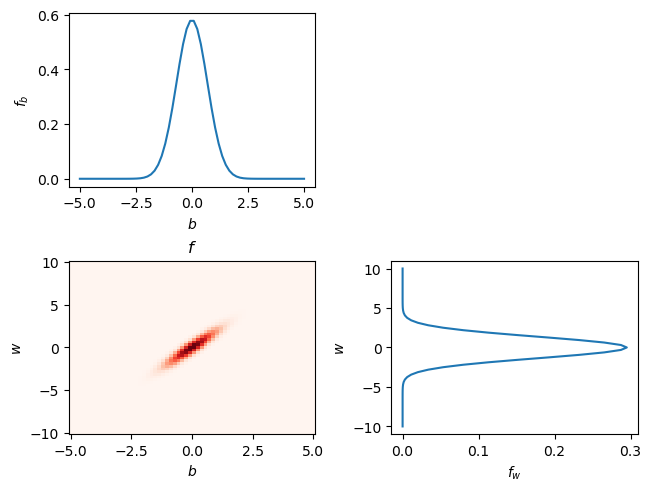

int f_WB dwdb = 1.000, t = 6.000 



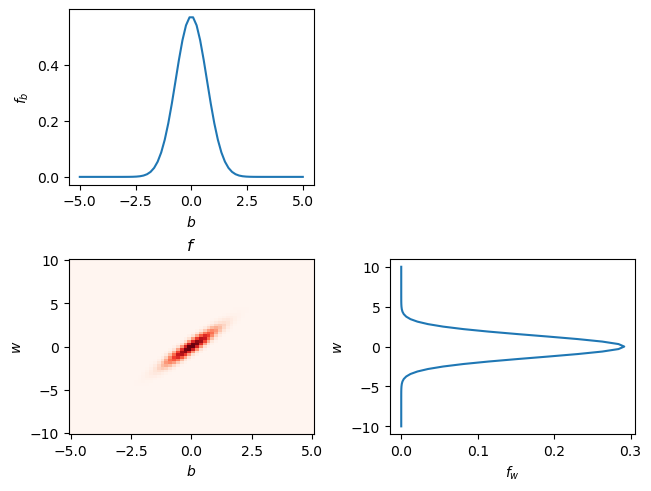

int f_WB dwdb = 1.000, t = 7.000 



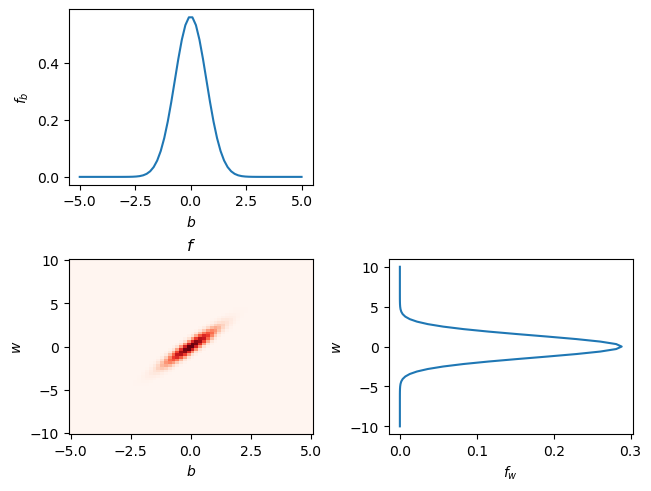

int f_WB dwdb = 1.000, t = 8.000 



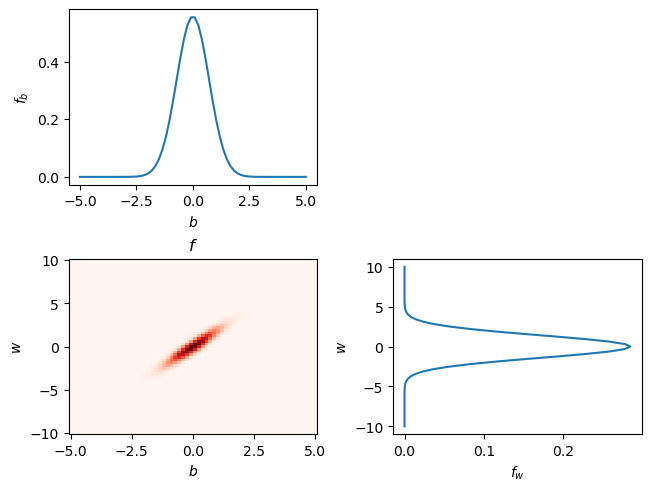

int f_WB dwdb = 1.000, t = 9.000 



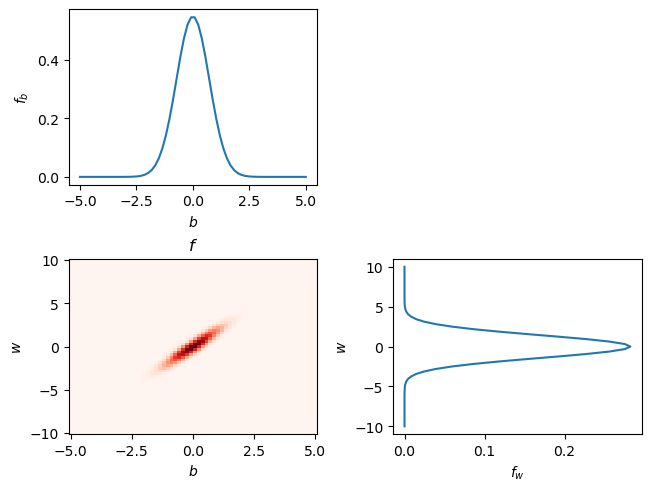

In [51]:
N_T = 10**5
T, Δt = np.linspace(0,10,N_T,retstep=True)
print('Δt = ',Δt)

# Initial conditions for f shape b, w
g = lambda z : np.exp(-z**2/2)/np.sqrt(2*np.pi)
f = np.outer( g(b), g(w) )
print('int f_WB(w,b;t=0) dwdb = %3.3f \n' % trapz(y=trapz(y=f,x=b,axis=0),x=w) )

# Flatten the input f for solver
solver(f.flatten(), b, w, T, Δt)

We observe the system develops a positive covariance $\mathbb{E}[WB] > 0$ and that it correctly conserves probability and that both distributions relax to a Gaussian. Similar to the previous problem we now wish to force this system to investigate if it can also capture the evolution of more complicated joint distributions. We choose a forcing which mimics Rayleigh-B\'enard convection

\begin{equation}
    \boldsymbol{D}^{(1)} f_{\boldsymbol{Y}} = \mathbb{E}_{WB|\partial \Omega} [ \boldsymbol{n} \cdot \nabla B ] f_{\boldsymbol{Y} | \partial \Omega}
\end{equation}  

which as $W=0$ at the boundary for no-slip boundary conditions, is equivalent to conditioning on $W=0$. Using simulation data to estimate this term, as shown in "Part2_forcing_RBC.py" shows that this term is approximately given by

\begin{equation}
    \boldsymbol{D}^{(1)} f_{\boldsymbol{Y}}(w=0,b) = -\underbrace{\mathcal{N}(\mu=-1,\sigma)}_{\text{top cold boundary at z=1}} + \underbrace{\mathcal{N}(\mu=1,\sigma)}_{\text{lower hot boundary at z=0}},
\end{equation}

where $\sigma$ is a small constant that depends on the variance of the forcing at the boundary. Below we write a new code which implements this forcing by added the forcing term on to the update provided by the previous solver.

In [52]:
# Define the forcing term
D1_f   = np.zeros((N_b, N_w))
Normal = lambda b,μ,σ=1: np.exp(-.5*((b - μ)/σ)**2)/np.sqrt(2*np.pi*(σ**2))

# Check we are at w = 0
i = (N_w - 1)//2
assert w[i] == 0.0

# Assign the forcing
D1_f[:,i] = 1e-01*(-Normal(b,μ=-1) + Normal(b,μ=1) )
D1_f = D1_f.flatten()

# Redefine the solver
def solve_forced(f, b, w, Δt, L_b, L_w, D_b, D_w):

  # a) Compute diffusion from W
  W = np.kron(np.ones(N_b),w)
  B = np.kron(b,np.ones(N_w))
  
  # b.1) Compute the expectation velocity  
  EW_cB = trapz(y=(W*f).reshape((N_b,N_w)), x=w, axis=1)/trapz(y=f.reshape((N_b,N_w)), x=w, axis=1)
  EW_cB = np.kron(EW_cB, np.ones(N_w)) 
  
  # b.2) Compute the expectation buoyancy  
  EB_cW = trapz(y=(B*f).reshape((N_b,N_w)), x=b, axis=0)/trapz(y=f.reshape((N_b,N_w)), x=b, axis=0)
  EB_cW = np.kron(np.ones(N_b), EB_cW) 
  
  # c) Define the RHS
  RHS_f = -D_b@(D1_f)
  RHS_w = -D_w@( B*f)          - (1/τ_W)*D_w@((B - EW_cB)*f) + 0.1*L_w@f
  RHS_b = -D_w@((B - EB_cW)*f) + (1/τ_B)*D_b@((B - EB_cW)*f) + 0.1*L_b@f
  
  # d) Update the PDF
  return f + Δt*(RHS_f + RHS_b + RHS_w)

def solver_forced(f, b, w, T, Δt):

  f_frames = []
  f_frames.append(f)

  L_b, L_w, D_b, D_w = operators_EXP(b, w) 

  # Loop over all time instants
  for n,t in enumerate(T):
  
    # 0) Plot the system out
    if n%(len(T)//10) == 0:
      print('int f_WB dwdb = %3.3f, t = %3.3f \n' %(trapz(y=trapz(y=f.reshape((N_b,N_w)),x=b,axis=0),x=w), t) )
      
      fig, ax = plt.subplots(nrows=2, ncols=2, layout='constrained')
      
      f_w = trapz(y=f.reshape((N_b,N_w)),x=b,axis=0)
      f_b = trapz(y=f.reshape((N_b,N_w)),x=w,axis=1)

      # First column
      ax[0,0].set_ylabel('$f_b$')
      ax[0,0].set_xlabel('$b$')
      ax[0,0].plot(b, f_b)

      ax[1,0].set_title(r'$f$')
      cf = ax[1,0].pcolormesh(b,w,f.reshape((len(b),len(w))).T, cmap='Reds')#, norm='log')
      #fig.colorbar(cf, ax=ax1)
      ax[1,0].set_xlabel('$b$')
      ax[1,0].set_ylabel('$w$')

      # First column
      fig.delaxes(ax[0,1])

      ax[1,1].set_ylabel('$w$')
      ax[1,1].set_xlabel('$f_w$')
      ax[1,1].plot(f_w, w)
      
      plt.show()

      B, W = np.meshgrid(b,w)
      fig, ax10 = plt.subplots(subplot_kw={"projection": "3d"})
      ax10.set_title(r'$f$')
      surf = ax10.plot_surface(B,W,f.reshape((len(b),len(w))).T, cmap='Reds', norm = 'log', linewidth=0, antialiased=False)
      ax10.set_xlabel('$b$')
      ax10.set_ylabel('$w$')
      plt.show()

    # 1) Update the mapping
    #f = enforce_bc(f, b, w)
    f = solve_forced(f, b, w, Δt, L_b, L_w, D_b, D_w)

    # 2) Grab the system state
    f_frames.append(f)

  return None

Specifying the same details we run the solver again.

Δt =  0.0002000040000800016
int f_WB(w,b;t=0) dwdb = 1.000 

int f_WB dwdb = 1.000, t = 0.000 



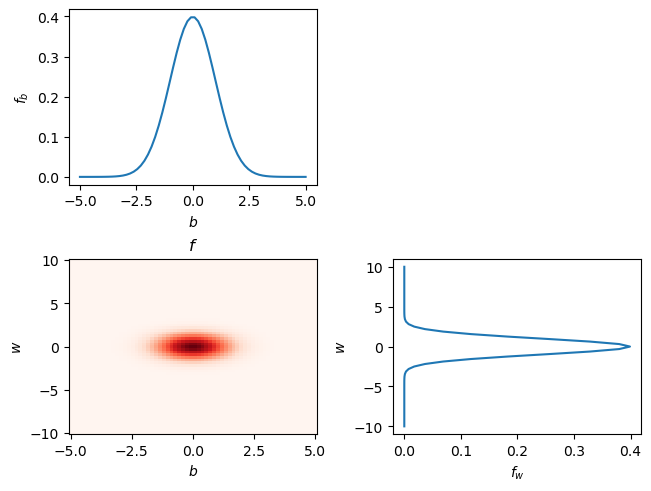

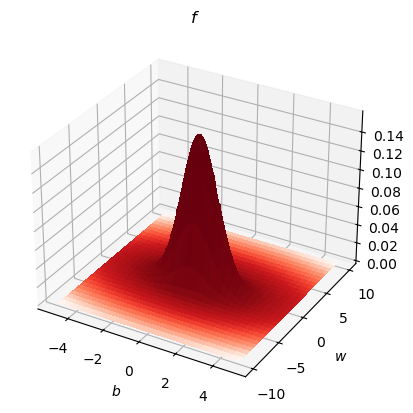

int f_WB dwdb = 1.000, t = 1.000 



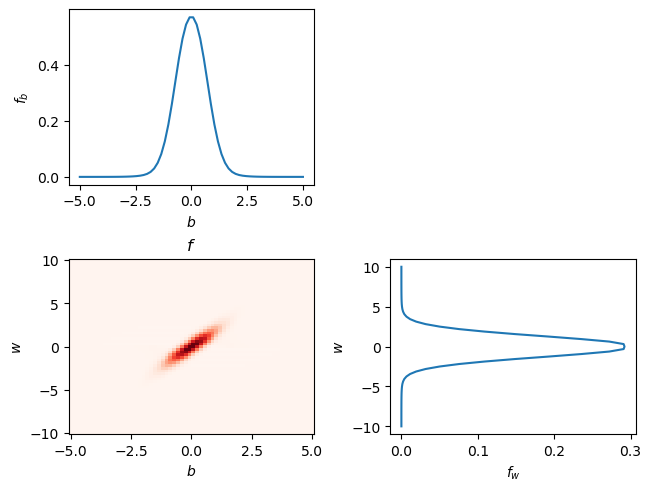

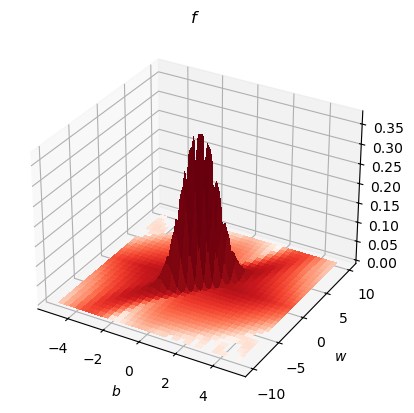

int f_WB dwdb = 1.000, t = 2.000 



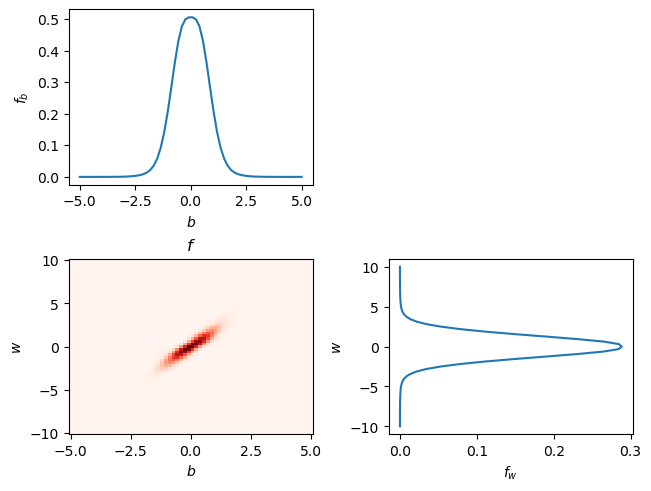

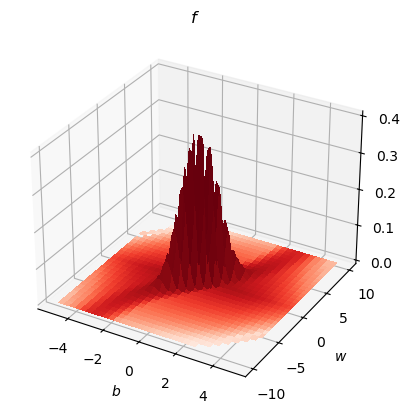

int f_WB dwdb = 1.000, t = 3.000 



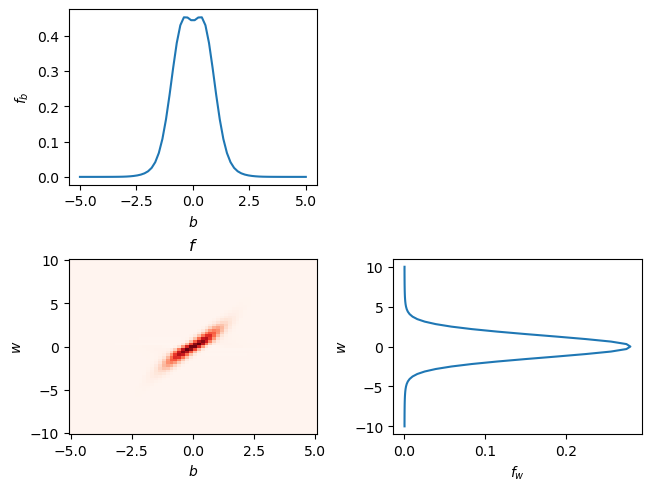

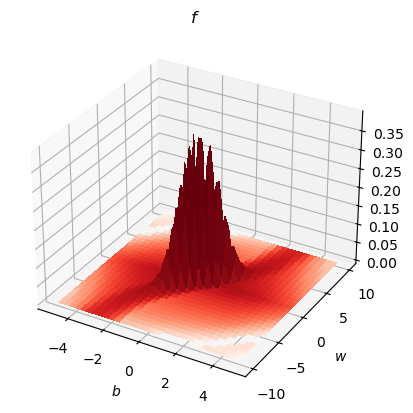

int f_WB dwdb = 1.000, t = 4.000 



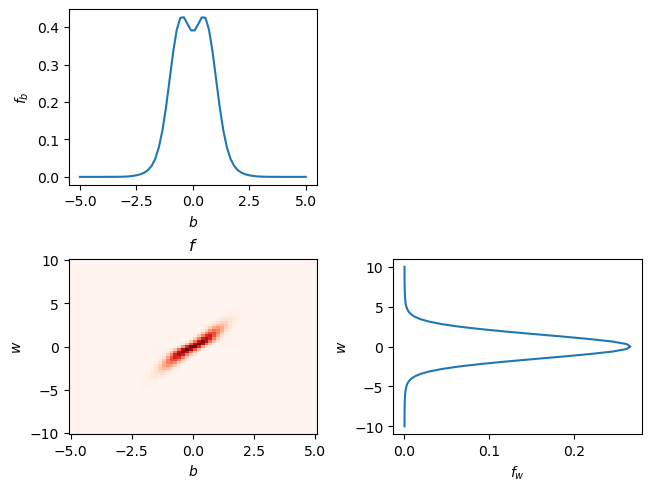

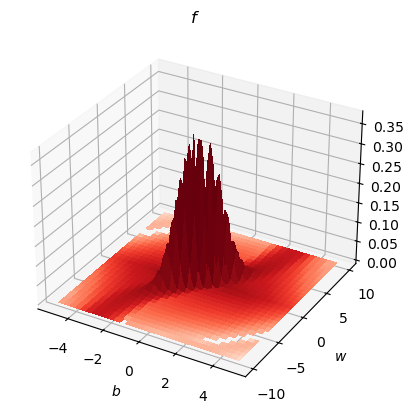

int f_WB dwdb = 0.999, t = 5.000 



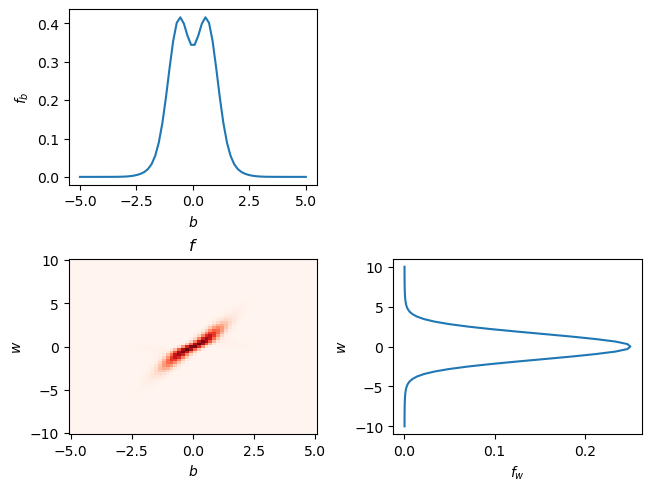

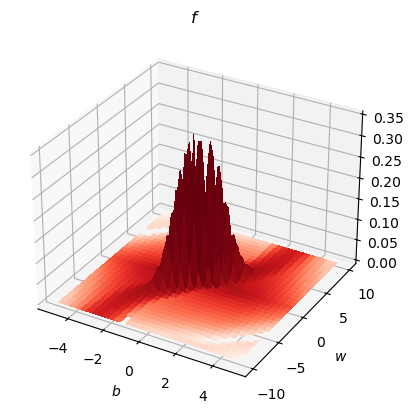

int f_WB dwdb = 0.999, t = 6.000 



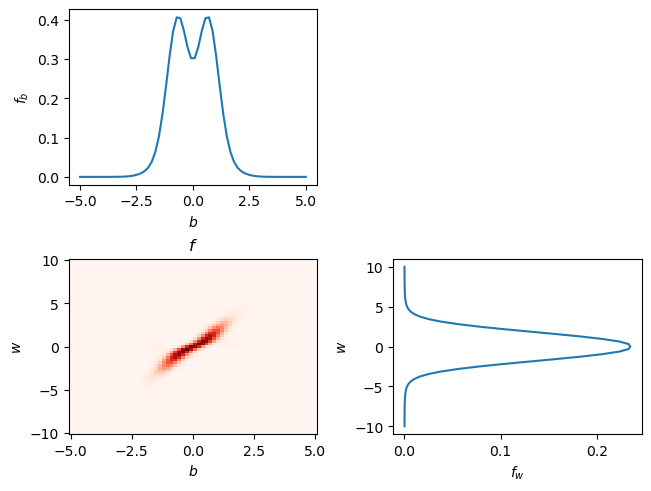

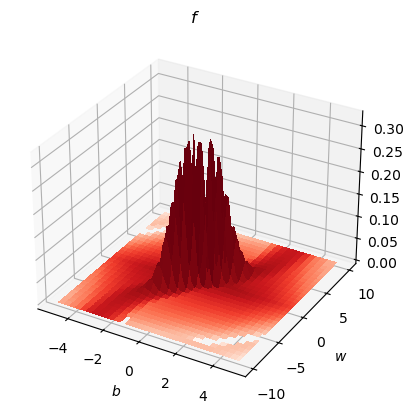

int f_WB dwdb = 0.999, t = 7.000 



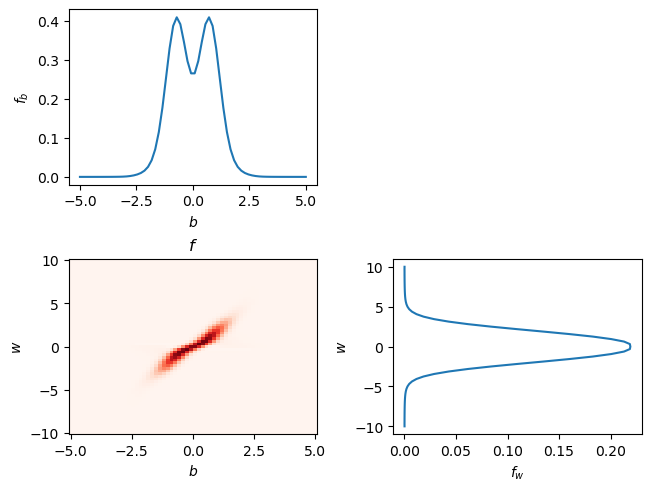

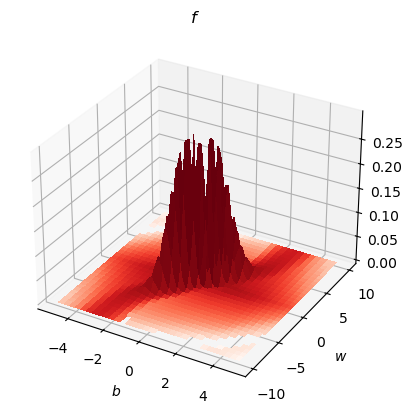

int f_WB dwdb = 0.999, t = 8.000 



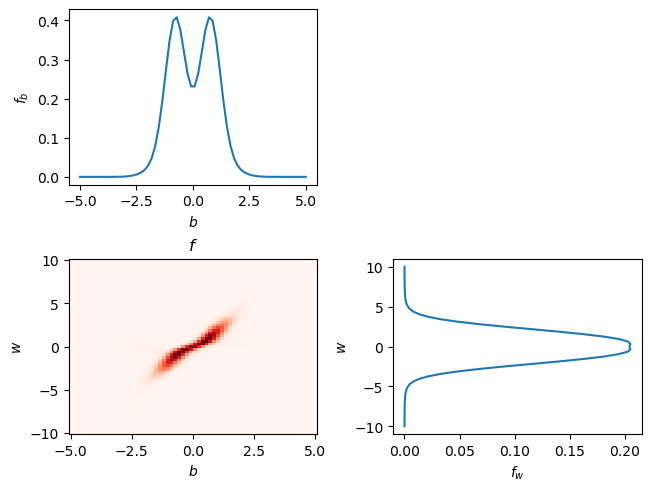

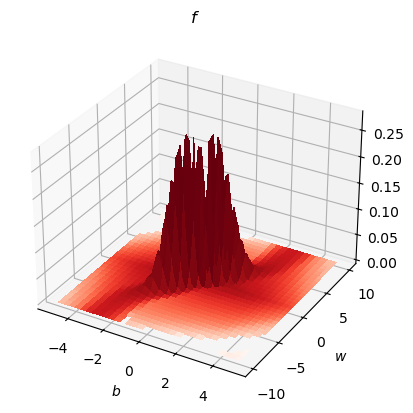

int f_WB dwdb = 0.999, t = 9.000 



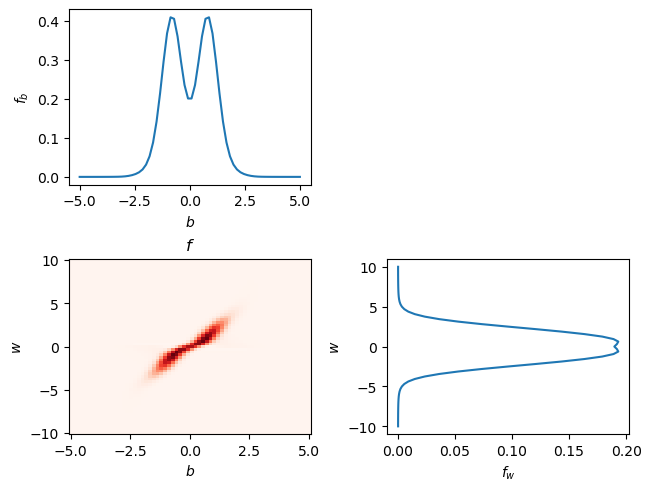

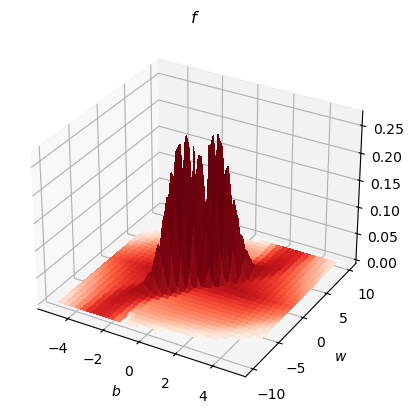

In [53]:
N_T = 5*10**4
T, Δt = np.linspace(0,10,N_T,retstep=True)
print('Δt = ',Δt)

# Initial conditions for f shape b, w
f = np.outer( Normal(b,μ=0,σ=1), Normal(w,μ=0,σ=1) )
print('int f_WB(w,b;t=0) dwdb = %3.3f \n' % trapz(y=trapz(y=f,x=b,axis=0),x=w) )

# Flatten the input f for solver
solver_forced(f.flatten(), b, w, T, Δt)